# Simple Neural Network for Multi-classification
**Softmax** regression is a simple fully-connected depth-1 neural network for classification task. Ground truth class is represented by the one-hot-encoding. The model intends to predict $P(y=i|X)$ for $i\in C$, thus $\hat y=\argmax_{i} P(y|X)$. The model assumes that $o$ is linear related to $x$, such that 
$$
o = Wx + b
$$
where $o\in \mathbb R^C$, $x\in \mathbb R^P$, and $W \in \mathbb R^{P\times C}$. To convert $o$ into a probability, the softmax is applied.
$$
\hat y = softmax(o) \text{  where  } softmax(y) = \frac{exp(o_i)}{\sum_j exp(o_j)}
$$
The mathematical derivation is not explained here.

## Loss Function: Cross Entropy
The output $\hat y$ can be interpreted as a conditional probability. Given the ground truth, we may check the probability that all predictions are correct.
$$
P(Y|X) = \prod_{i=1}^nP(y^{(i)}|x^{(i)})
$$
Taking the negative log yields,
$$
-logP(Y|X) = \sum^n_{i=1}-logP(y^{(i)}|x^{(i)}) = -\sum^n_{i=1}\sum^C_{j=1}y_jlog\hat y_j
$$
Since $y$ always has 100% probability for one class, the inner sum vanishes
$$
l(y, \hat y) = -\sum^n_{i=1}\hat y_j^Tlog\hat y_j
$$

We may also simplify the original equation:
\begin{aligned}
l(y,\hat y) &= -\sum^C_{j=1}y_jlog\frac{exp(o_j)}{\sum^C_{k=1}exp(o_k)} \\
&= \sum^C_{j=1}y_jlog\sum^C_{k=1}exp(o_k) - \sum^C_{j=1}y_jo_j \\
&= log\sum^C_{k=1}exp(o_k) - \sum^C_{j=1}y_jo_j 
\end{aligned}

Taking partial derivative w.r.t any $o_j$ yields
$$
\partial_{o_j} l(y,\hat y) = \frac{exp(o_j)}{\sum^C_{k=1}exp(o_k)} - y_j = softmax(o_j) - y_j
$$
which is, intuitively, the difference between predicted and actual probability.

## Example

In [43]:
import dl
import torch
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Module: Iris Dataset

In [44]:
class ClassificationData(dl.DataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        data_temp = load_iris()
        self.X = torch.tensor(data_temp['data'], dtype=torch.float32)
        self.y = torch.tensor(OneHotEncoder(sparse_output=False).fit_transform(
            torch.tensor(data_temp['target']).reshape(-1,1)
            ), dtype=torch.float32)
        self.num_train = self.X.shape[0]

## Model Definition

In [108]:
def cross_entropy(y, y_hat):
    return -sum(
        [y[ind,:].T @ torch.log(y_hat[ind,:]) for ind in range(y.shape[0])]
        )

class SoftMaxRegression(dl.Module):
    def __init__(self, C, P, eta, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        self.W = torch.normal(0, sigma, (P, C), requires_grad=True)
        self.b = torch.zeros(C, requires_grad=True)
    
    def forward(self, X):
        return torch.nn.functional.softmax(X @ self.W + self.b)
    
    def loss(self, y_hat, y):
        return cross_entropy(y, y_hat)

## Optimizer Definition

In [109]:
@dl.add_to_class(SoftMaxRegression)
def configure_optimizers(self):
    return dl.SGD([self.W, self.b], self.eta)

In [123]:
data = ClassificationData()
model = SoftMaxRegression(3,4,0.01)
trainer = dl.Trainer(100)
trainer.fit(model, data)

C:\Users\25077\AppData\Local\Temp\ipykernel_16468\3995495571.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(X @ self.W + self.b)


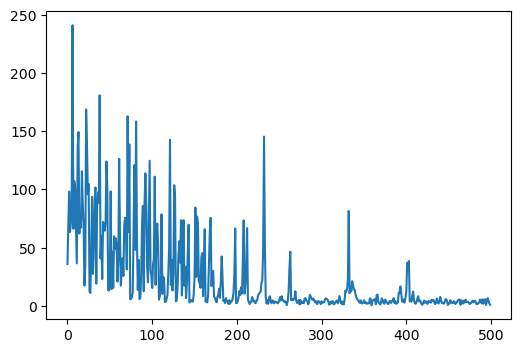

In [124]:
trainer.plot_loss()

In [126]:
y_hat = torch.argmax(
    torch.nn.functional.softmax(data.X @ trainer.optim.params[0] + trainer.optim.params[1]),
    axis = 1
)

C:\Users\25077\AppData\Local\Temp\ipykernel_16468\738219378.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(data.X @ trainer.optim.params[0] + trainer.optim.params[1]),


In [136]:
(torch.argmax(data.y, axis=1) == y_hat).mean(dtype=float)

tensor(0.9733, dtype=torch.float64)